In [56]:
from itertools import combinations
import numpy as np
import scipy.optimize as opt
import tifffile as tf
import matplotlib.pyplot as plt

In [4]:
img_stack = tf.imread(r'C:\Users\pattammattel\Desktop\MIDAS_Admin\sample_data\Site4um.tiff')
e_list = np.loadtxt(r'C:\Users\pattammattel\Desktop\MIDAS_Admin\sample_data\Site4um.txt')
refs = np.loadtxt(r'C:\Users\pattammattel\Desktop\MIDAS_Admin\sample_data\fe_refs.nor')

In [7]:
def interploate_E(refs, e):
    n = np.shape(refs)[1]
    refs = np.array(refs)
    ref_e = refs[:, 0]
    ref = refs[:, 1:n]
    all_ref = []
    for i in range(n - 1):
        ref_i = np.interp(e, ref_e, ref[:, i])
        all_ref.append(ref_i)
    return np.array(all_ref)

new_ref = interploate_E(refs, e_list)

In [8]:
np.shape(img_stack),np.shape(e_list),np.shape(new_ref)

((57, 91, 95), (57,), (3, 57))

In [77]:
from skimage.transform import resize
img_stack_resized = resize(img_stack, (57,45, 47))

In [78]:
img_stack_resized.shape

(57, 45, 47)

In [9]:
im_array = np.reshape(img_stack, (57,91*95))

In [13]:
np.shape(new_ref.T),np.shape(im_array[:,5000])

((57, 3), (57,))

In [16]:
coeffs, r = opt.nnls(new_ref.T, im_array[:,5000])

In [17]:
coeffs_arr = []
for i in range(np.shape(im_array)[-1]):
    coeffs, r = opt.nnls(new_ref.T, im_array[:,i])
    coeffs_arr.append(coeffs)

In [53]:
def xanes_fitting(im_stack, e_list, refs, method='NNLS'):
    """Linear combination fit of image data with reference standards"""
    en,im1,im2 = np.shape(im_stack)

    int_refs = (interploate_E(refs, e_list))
    im_array = im_stack.reshape(en, im1*im2)

    if method == 'NNLS':
        
        coeffs_arr = []
        r_factor_arr = []
        
        for i in range(im1*im2):
            coeffs, r = opt.nnls(int_refs.T, im_array[:,i])
            coeffs_arr.append(coeffs)
            r_factor_arr.append(r)
            
        abundance_map = np.reshape(coeffs_arr,(im1,im2,-1))
        r_factor = np.reshape(r_factor_arr,(im1,im2))

    return abundance_map,r_factor

In [79]:
mp,rf = xanes_fitting(img_stack_resized, e_list, refs, method='NNLS')

In [80]:
np.shape(mp)

(45, 47, 3)

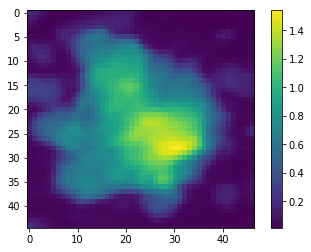

In [81]:
plt.imshow(mp[:,:,0])
plt.colorbar()

In [67]:
def normalize(image_array, norm_point=-1):
    a, b, c = np.shape(image_array)
    spec2D_Matrix = np.reshape(image_array, (a, (b * c)))
    norm_stack = np.zeros(np.shape(spec2D_Matrix))
    tot_spec = np.shape(spec2D_Matrix)[1]

    for i in range(tot_spec):
        norm_spec = spec2D_Matrix[:, i] / (spec2D_Matrix[:, i][norm_point])
        norm_stack[:, i] = norm_spec

    norm_stack = np.reshape(norm_stack, (a, b, c))
    return norm_stack

In [68]:
stk = normalize(img_stack, norm_point=-1)

In [71]:
img_stack/img_stack[-1].max()

(57, 91, 95)